### Deploying Functions on Watson Machine Learning - a hands on example

This notebook shows an example of how to deploy a function in Watson Machine Learning. This notebook includes the following steps.

+ **Part 1** deploys a simple function on Watson Machine Learning (WML). This function does not involve any machine learning (ML) model. It simply calculates the missing values in a dataset and returns the result.
+ **Part 2** involves building a custom model using sklearn and deploying a function to score using that model.

In [2]:
import pandas as pd
import numpy as np

### Part 1

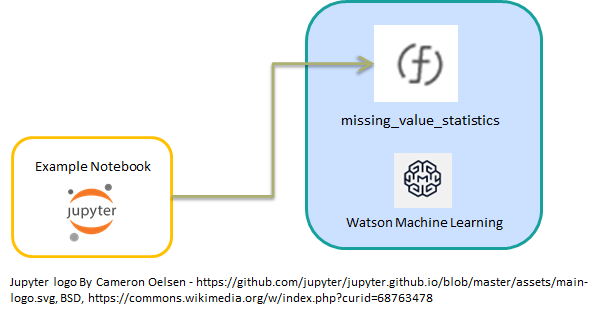

###### Define a simple function

For additional details see the Watson Machine Learning [documentation here](https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/ml-deploy-py-function-write.html?audience=wdp#py)

In [4]:
def missing_value_statistics():
    def score(scoring_payload):
        import pandas as pd
        values = scoring_payload['input_data'][0]['values']
        fields = scoring_payload['input_data'][0]['fields']
        df = pd.DataFrame(values, columns=fields)
        # Copy the names of the fields from the input payload, and return the missing value count for each one of them
        return {'predictions': [{'fields': fields, 'values': df.isna().sum().tolist()}]}
    return score

###### Test the function defined above

In [5]:
test_data = np.random.normal(25, 12, (15, 4))
# Randomly insert some NaNs
for row_index in range(0,15):
    row_data = test_data[row_index]
    col_index = np.random.choice(range(0, 4))
    test_data[row_index][col_index:] = np.nan

print(test_data)
scoring_payload = {"input_data": [{"fields":['var_'+str(n) for n in range(1, 5)], "values": test_data}]}
funcion_test_result = missing_value_statistics()(scoring_payload)
print(funcion_test_result) # print a few results

[[27.62075167 43.14793427 37.6450585          nan]
 [25.76512374 23.3169836   8.8985051          nan]
 [        nan         nan         nan         nan]
 [37.04585339 34.05000685         nan         nan]
 [37.13179156         nan         nan         nan]
 [19.6280071   8.64174935         nan         nan]
 [34.27656308 29.84313866         nan         nan]
 [36.35454193 34.97580371 26.67666455         nan]
 [        nan         nan         nan         nan]
 [-1.08135309         nan         nan         nan]
 [38.72537683 24.34139435  5.32234652         nan]
 [26.76984699 10.97674935 44.56970614         nan]
 [37.37917658 16.32476966 26.39368567         nan]
 [16.31205562         nan         nan         nan]
 [16.01192915 20.55052056         nan         nan]]
{'predictions': [{'fields': ['var_1', 'var_2', 'var_3', 'var_4'], 'values': [2, 5, 9, 15]}]}


##### Define Watson Machine Learning (WML) credentials for deployment

In [7]:
# @hidden_cell
import os
from ibm_watson_machine_learning import APIClient
wml_credentials = {
                   "url":  os.environ['RUNTIME_ENV_APSX_URL'], 
                   "token": os.environ['USER_ACCESS_TOKEN'],
                   "instance_id": "openshift",
                   "version" : "4.0"
                  } 
deployment_space = 'MAS-Testing-Deployment-Space'

###### Instantiate WML connection

In [8]:
wml_client = APIClient(wml_credentials)
deployment_spaces = wml_client.spaces.get_details()
deployment_space_id = [entry['metadata']['id'] for entry in deployment_spaces['resources'] if entry['entity']['name'] == deployment_space][0]
print(deployment_space_id)
wml_client.set.default_space(space_uid = deployment_space_id)

ad23ca84-369b-412a-b737-b04da28c39c2


'SUCCESS'

###### Deploy the function defined above in WML

In [ ]:
missing_values_fn_meta_data = {
    wml_client.repository.FunctionMetaNames.NAME: 'missing_value_statistics',
    wml_client.repository.FunctionMetaNames.SOFTWARE_SPEC_UID: wml_client.software_specifications.get_id_by_name("default_py3.8")
}

stored_mvfn_descriptor = wml_client.repository.store_function(function=missing_value_statistics, meta_props=fn_meta_data)
print('Stored function descriptor (not deployed yet) ', '\n', stored_mvfn_descriptor)

missing_values_fn_deployment_metadata = {
    wml_client.deployments.ConfigurationMetaNames.NAME: 'Missing value statistics example function deployment',
    wml_client.deployments.ConfigurationMetaNames.ONLINE: {}
}

deployed_mvfn_descriptor = wml_client.deployments.create(wml_client.repository.get_function_uid(stored_mvfn_descriptor), 
                                                       meta_props=deployment_metadata)
print('Function deployment descriptor ', '\n', deployed_mvfn_descriptor)

###### Visual verification of the deployed function

The simple function that was deployed on Watson Machine Learning in the previous cell, can be visually located and verified from the deployment console. 

Navigate to `Projects > Deployments` on the CP4D Watson Studio console, and pick the deployment space (in this example, the deployment space is `MAS_Testing_Deployment_Space`), go to the `Assets` tab as shown in the following screenshot.

The data asset should show up under the `Functions` folder as illustrated in the screenshot below. Since we have not deployed any other artifacts yet, this is the only thing you should see (unless of course, you deployed other models or functions or data assets in the past that still exist in the repository).

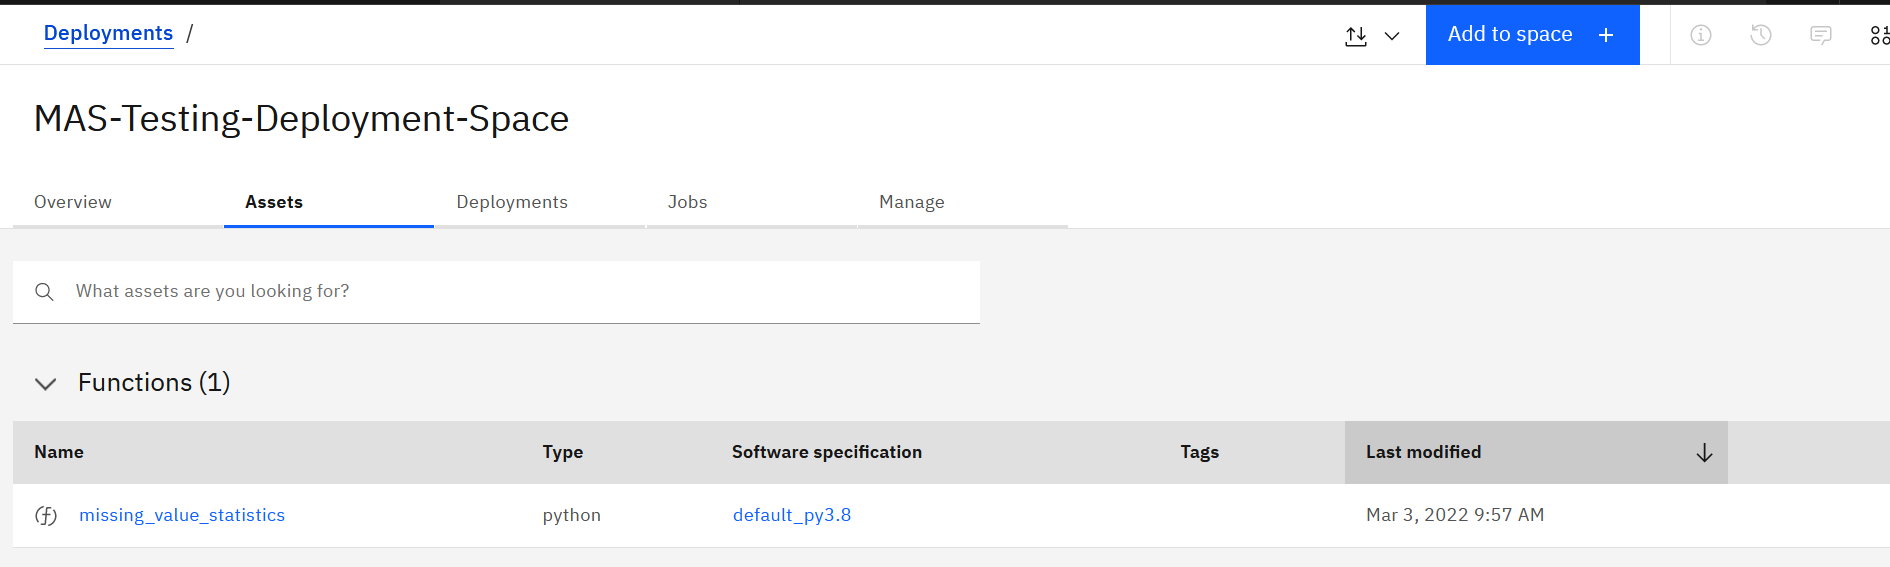

###### Score some sample data using the endpoint for the function (`missing_value_statistics`) that was just deployed in WML

In [28]:
mv_scoring_payload = {"input_data": [{"fields":['var_'+str(n) for n in range(1, 5)], "values": test_data}]}

stored_mvfn_deployment_id = wml_client.deployments.get_uid(deployed_mvfn_descriptor)
print('ID of the missing value statistics function stored in WML = ', stored_mvfn_deployment_id)

scoring_result = wml_client.deployments.score(stored_mvfn_deployment_id, mv_scoring_payload)

if "error" in scoring_result:
    print(scoring_result["error"])
else:
    print(scoring_result['predictions'][0]['fields'][0:5])
    print(scoring_result['predictions'][0]['values'][0:5]) # print a few results


ID of the missing value statistics function stored in WML =  bac61294-4a64-4ebd-bf76-6419df123405
['var_1', 'var_2', 'var_3', 'var_4']
[2, 4, 15, 15]
ID of the missing value statistics function stored in WML =  598ad907-abfd-401b-a695-cb82063298e7
['var_1', 'var_2', 'var_3', 'var_4']
[3, 7, 10, 15]


### Part 2

In this section a model is trained on a dataset, deployed in WML, and a function is created to score a new set of data using the deployed model.

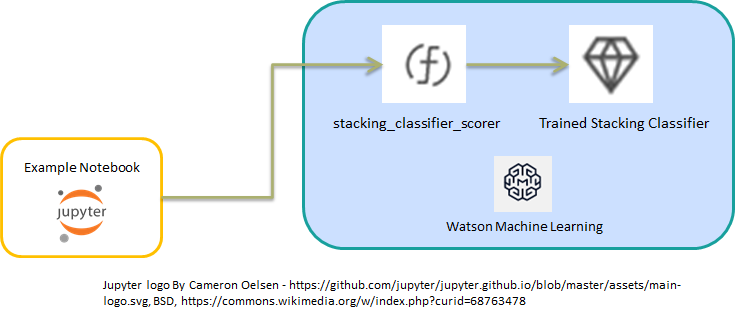

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, recall_score, precision_score, f1_score, classification_report

##### Make up some training data

In [11]:
X, Y = make_classification(n_samples=8000, n_features=10, n_informative=6, n_redundant=2, n_repeated=0, n_classes=2, 
                           n_clusters_per_class=2, weights=[0.57, 0.43], flip_y=0.01, class_sep=1.0, hypercube=True, shift=0.4, scale=1.0, 
                           shuffle=True, random_state=65)

##### Split into Train and Test buckets

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

##### Test with some training data and vizualize the results

In [ ]:
ss = StandardScaler()
gpc = GaussianProcessClassifier()
lsvc = LinearSVC()
lda = LinearDiscriminantAnalysis()
estimator_sequence = [('gpc', make_pipeline(StandardScaler(), gpc)), ('lda', make_pipeline(StandardScaler(), lda)), 
               ('lsvc', make_pipeline(StandardScaler(), lsvc))]
stacking_classifier = StackingClassifier(estimators = estimator_sequence, final_estimator = GradientBoostingClassifier())

stacking_classifier.fit(X_train, Y_train)
sc_score = stacking_classifier.score(X_test, Y_test)
print('Score = ', sc_score)
Y_pred = stacking_classifier.predict(X_test)
print(Y_pred)
class_probabilities = stacking_classifier.predict_proba(X_test)
print(class_probabilities)

In [33]:
print(classification_report(Y_pred, Y_test))

              precision    recall  f1-score   support

           0       0.91      0.90      0.91      1143
           1       0.87      0.89      0.88       857

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1128
           1       0.90      0.87      0.88       872

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000



###### Deploy the trained model on WML

In [ ]:
ssid = wml_client.software_specifications.get_id_by_name('default_py3.8')
print('Software Spec UID = ', ssid)
metadata = {
            wml_client.repository.ModelMetaNames.NAME: 'Trained Stacking Classifier',
            wml_client.repository.ModelMetaNames.TYPE: 'scikit-learn_0.23',
            wml_client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: ssid
}
stored_model_descriptor = wml_client.repository.store_model(model=stacking_classifier, meta_props=metadata)
print(stored_model_descriptor)

metadata = {
    wml_client.deployments.ConfigurationMetaNames.NAME: "Example Stacking Classifier Model",
    wml_client.deployments.ConfigurationMetaNames.ONLINE: {}
}
deployed_model_descriptor = wml_client.deployments.create(wml_client.deployments.get_id(stored_model_descriptor), 
                                                          meta_props=metadata)
print(deployed_model_descriptor)

###### Visual verification of the deployed asset

The trained model that was deployed on Watson Machine Learning in the previous cell, can be visually located and verified from the deployment console. 

Navigate to `Projects > Deployments` on the CP4D Watson Studio console, and pick the deployment space (in this example, the deployment space is `MAS_Testing_Deployment_Space`), go to the `Assets` tab as shown in the following screenshot.

The data asset should show up under the `Models` folder as illustrated in the screenshot below. 

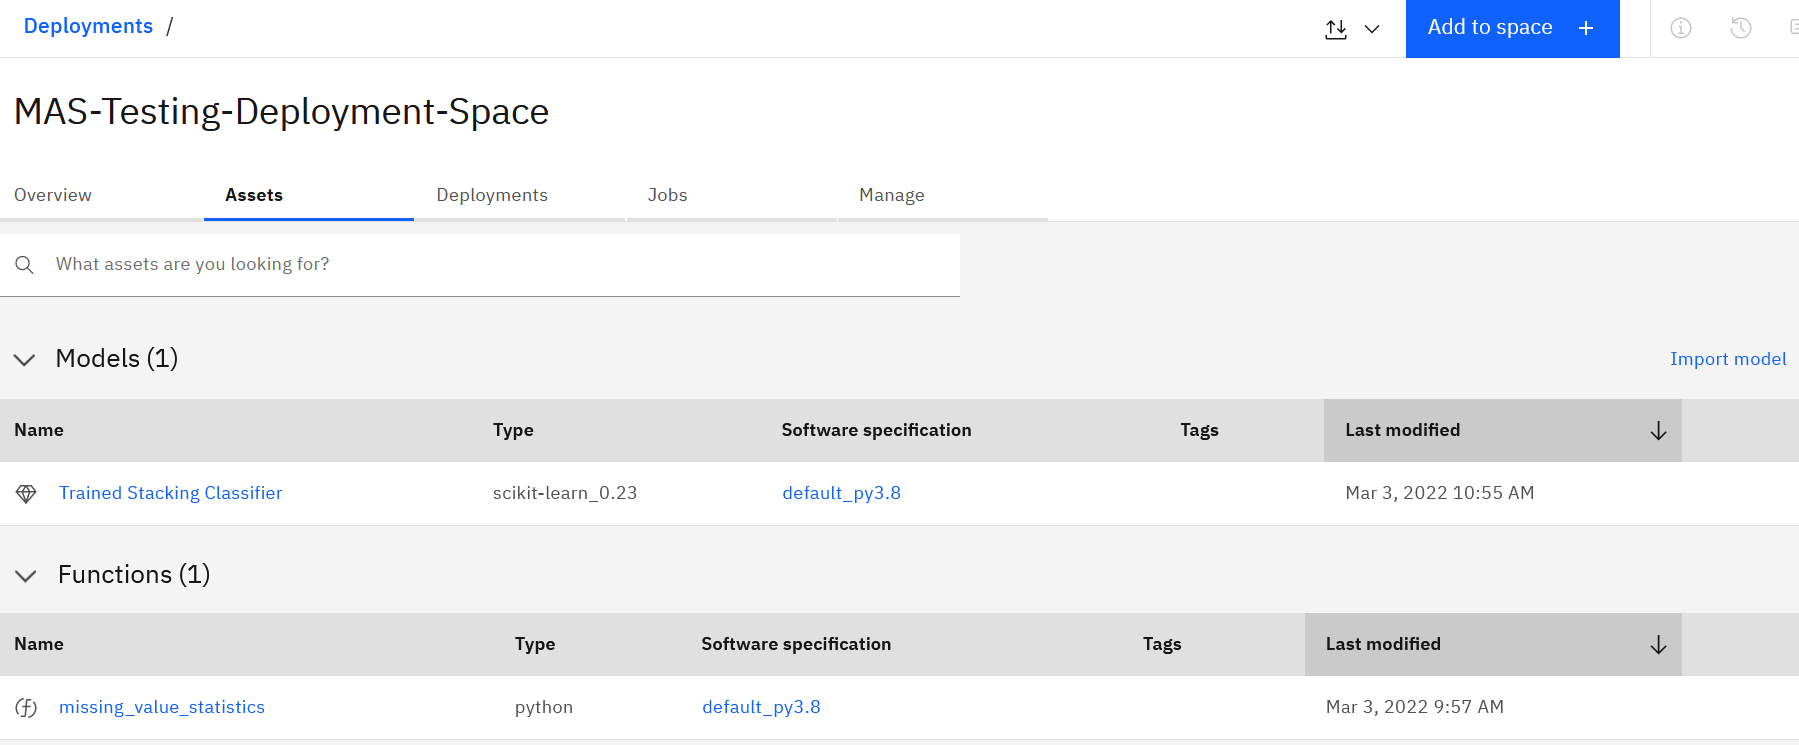

###### Define a function that scores using the model saved in the previous step. This function will be deployed on WML

In [35]:
wml_access_info = {'wml_credentials':wml_credentials, 'deployment_space_id':deployment_space_id}
def stacking_classifier_scorer(wml_access_info = wml_access_info, deployment_descriptor = deployed_model_descriptor):
    def score(scoring_payload):
        scoring_result = None
        try:
            from ibm_watson_machine_learning import APIClient
            wml_client = APIClient(wml_access_info['wml_credentials'])
            wml_client.set.default_space(wml_access_info['deployment_space_id'])
            scoring_result = wml_client.deployments.score(wml_client.deployments.get_id(deployed_model_descriptor), scoring_payload)
        except Exception as e:
            print('Exception encountered while scoring - ', str(e))
            scoring_result = {'predictions': [{'values': [repr(e)]}]}
        return scoring_result
    return score

##### Quick test of the deployed model using the function `stacking_classifier_scorer` defined above

In [36]:
scoring_payload = {"input_data": [{"values": X_test}]} 
funcion_test_result = stacking_classifier_scorer(wml_access_info, deployed_model_descriptor)(scoring_payload)
print(funcion_test_result['predictions'][0]['values'][0:5]) # print a few results

[[1, [0.024418743642261487, 0.9755812563577385]], [0, [0.9834723107402948, 0.016527689259705193]], [0, [0.9886239272856167, 0.011376072714383397]], [1, [0.03245777822334761, 0.9675422217766524]], [1, [0.11900235094153622, 0.8809976490584638]]]
[[0, [0.7146980118631547, 0.2853019881368452]], [0, [0.8240056277170141, 0.17599437228298587]], [0, [0.9892656195823057, 0.010734380417694275]], [1, [0.4407740187649505, 0.5592259812350495]], [0, [0.9683553444475077, 0.03164465555249229]]]


##### Deploying `stacking_classifier_scorer` on WML

In [ ]:
fn_meta_data = {
    wml_client.repository.FunctionMetaNames.NAME: 'stacking_classifier_scoring_function',
    wml_client.repository.FunctionMetaNames.SOFTWARE_SPEC_UID: wml_client.software_specifications.get_id_by_name("default_py3.8")
}

stored_fn_descriptor = wml_client.repository.store_function(function=stacking_classifier_scorer, meta_props=fn_meta_data)
print('Stored function descriptor (not deployed yet) ', '\n', stored_fn_descriptor)

deployment_metadata = {
    wml_client.deployments.ConfigurationMetaNames.NAME: 'Stacking classifier scoring function deployment',
    wml_client.deployments.ConfigurationMetaNames.ONLINE: {}
}

deployed_fn_descriptor = wml_client.deployments.create(wml_client.repository.get_function_uid(stored_fn_descriptor), 
                                                       meta_props=deployment_metadata)
print('Function deployment descriptor ', '\n', deployed_fn_descriptor)

###### Visual verification of the deployed function from the CP4D console

As we did in the earlier sections we can visually verify if the deployed function shows up in Watson Machine Learning deployment space. 

Navigate to `Projects > Deployments` on the CP4D Watson Studio console, and pick the deployment space (in this example, the deployment space is `MAS_Testing_Deployment_Space`), go to the `Assets` tab as shown in the following screenshot.

The newly deployed function should show up under the `Functions` folder as illustrated in the screenshot below.  This should also show the previous function and the model we deployed earlier.

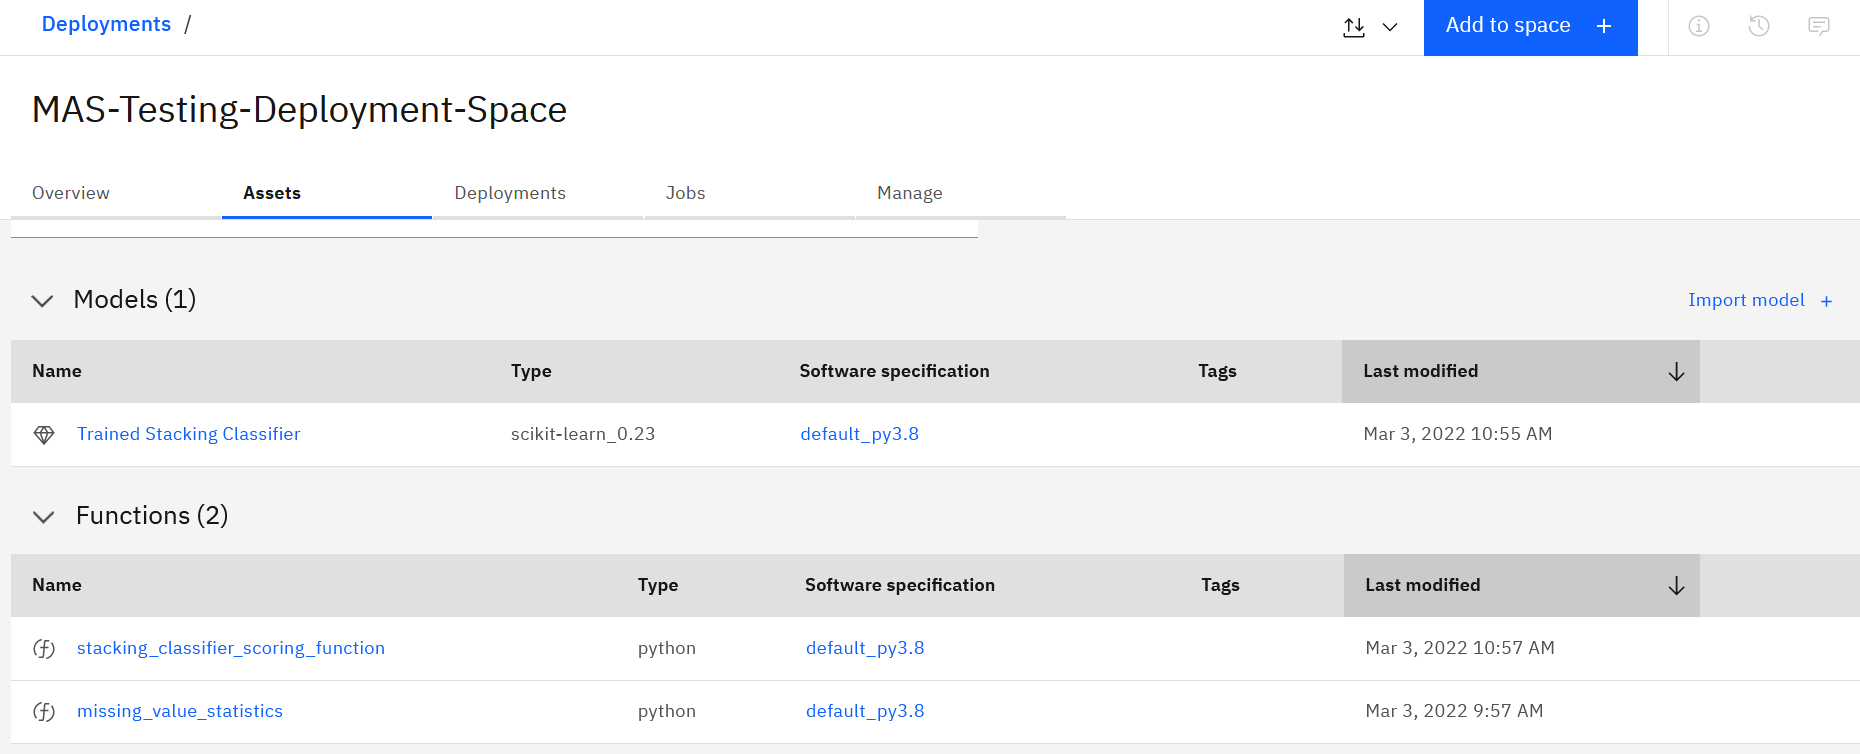

###### Test the function that was just deployed in Watson Machine Learning 

In [38]:
# The following IDs and URLs can also be retrieved by directly accessing the JSON output. Like for deployment_id, one can use the expression stored_fn_descriptor['metadata']['id'], 
# but using WML APIs is safer as that will protect the client code against any internal schema changes WML team may make in the future. 
stored_fn_deployment_id = wml_client.deployments.get_uid(deployed_fn_descriptor)
print('ID of the stored function in WML = ', stored_fn_deployment_id)

scoring_payload = {"input_data": [{"values": X_test}]}   
scoring_result = wml_client.deployments.score(stored_fn_deployment_id, scoring_payload)
if "error" in scoring_result:
    print(scoring_result["error"])
else:
    print(funcion_test_result['predictions'][0]['values'][0:5]) # print a few results

ID of the stored function in WML =  f39384f2-641e-492a-bda8-3cb3a5fd9068
[[1, [0.024418743642261487, 0.9755812563577385]], [0, [0.9834723107402948, 0.016527689259705193]], [0, [0.9886239272856167, 0.011376072714383397]], [1, [0.03245777822334761, 0.9675422217766524]], [1, [0.11900235094153622, 0.8809976490584638]]]
ID of the stored function in WML =  49838652-c8d0-4dc2-9289-b88746ea3939
[[0, [0.7146980118631547, 0.2853019881368452]], [0, [0.8240056277170141, 0.17599437228298587]], [0, [0.9892656195823057, 0.010734380417694275]], [1, [0.4407740187649505, 0.5592259812350495]], [0, [0.9683553444475077, 0.03164465555249229]]]


###### End of the exercise